In [1]:
import numpy as np
import pandas as pd
import os
import torch
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm
import dgl
import sklearn
from sklearn import svm
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from collections import Counter
from sklearn.datasets import make_classification
# from imblearn.over_sampling import SMOTE 
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

Using backend: pytorch


# Load Features and Process them

## CNN features

In [655]:
df

,0,1,2,3,4,5,6,7,8,9,...,119,120,121,122,123,124,125,126,127,label
356,1.509110,0.000026,0.000030,0.008860,1.787532,1.820176,1.459725,2.762734,0.000000,0.000661,...,2.284463,7.400074,0.000000,0.000307,0.066123,8.044013,0.377691,0.001592,0.000047,disco
642,0.000000,3.091655,0.000006,3.316332,1.675758,5.876616,0.000512,0.340878,0.054068,6.893812,...,3.184980,2.295089,3.563853,0.626824,5.310542,0.343888,0.046441,0.696207,7.402304,metal
382,3.406869,0.034247,2.085608,6.150986,0.119703,0.000613,0.558177,0.244752,0.000000,0.000000,...,1.750640,0.000000,0.000816,4.515682,0.070255,0.052049,5.523344,6.325647,0.096039,disco
204,0.001781,5.825836,0.058726,0.000344,0.000000,0.002536,0.098367,0.003755,4.162414,1.506625,...,0.000788,0.000000,1.289328,0.721557,0.115574,5.473532,0.628931,3.828847,0.000000,country
735,6.287628,2.674050,0.000000,0.284599,0.000000,0.000000,3.518925,0.111027,2.880753,7.332430,...,4.322373,3.909558,0.000005,1.236447,0.021012,0.037472,0.000736,3.547906,0.182721,pop
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
929,1.496672,0.000218,0.191635,0.000000,0.000105,4.317069,4.269656,0.004838,1.013397,0.000000,...,0.000000,4.235231,0.628908,0.000000,0.000000,1.698730,2.122913,0.000000,0.423640,rock
92,1.618617,0.015381,0.005666,0.430449,6.135981,0.000000,0.000043,0.299494,0.293462,13.580737,...,2.023359,0.000100,0.035773,1.362145,1.903149,0.000000,0.072994,6.946867,0.003299,blues
334,1.877472,5.211968,2.178352,0.265589,0.000000,0.003805,0.000000,0.000000,2.514956,0.984210,...,1.975279,0.121809,7.651944,0.471602,0.333539,4.351283,3.648504,0.000556,0.002384,disco
683,0.059006,5.575052,3.720339,2.219304,4.378950,0.000073,0.001062,0.000000,1.483292,0.000000,...,0.000073,2.245529,0.000010,2.465793,4.273980,0.000000,3.097410,0.000014,2.778753,metal


In [3]:
df=pd.read_csv('CNN_featrues.csv')
df = df.iloc[: , 1:]
df['label'] = ''
df['label'].iloc[0:100] = 'blues'
df['label'].iloc[100:200] = 'classical'
df['label'].iloc[200:300] = 'country'
df['label'].iloc[300:400] = 'disco'
df['label'].iloc[400:500] = 'hiphop'
df['label'].iloc[500:600] = 'jazz'
df['label'].iloc[600:700] = 'metal'
df['label'].iloc[700:800] = 'pop'
df['label'].iloc[800:900] = 'reggae'
df['label'].iloc[900:1000] = 'rock'

#df=df[(df.label=='blues')|(df.label=='jazz')]
df=df.sample(n =1000)
df.label.value_counts()
X=StandardScaler().fit_transform(np.array(df.iloc[:,:-1],dtype=float))
class_list=df.iloc[:,-1]
converter=LabelEncoder()
y=converter.fit_transform(class_list)
print(X.shape,y.shape)
# X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.33)
# print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

X_train=X[0:670,:]
y_train=y[0:670]
X_test=X[670:,:]
y_test=y[670:]

print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

mfccs_total=X
labels_total=y
labels_train=y_train
labels_test=y_test
kpca_mfccs_total=mfccs_total

(1000, 128) (1000,)
(670, 128) (330, 128) (670,) (330,)


/Users/shuofeng/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


## mcff features

In [4]:
df=pd.read_csv('./mfcc/features_30_sec.csv')
df=df.drop(labels="filename",axis=1)
#df=df[(df.label=='blues')|(df.label=='jazz')]
df=df.sample(n =1000)
df.label.value_counts()
X=StandardScaler().fit_transform(np.array(df.iloc[:,:-1],dtype=float))
class_list=df.iloc[:,-1]
converter=LabelEncoder()
y=converter.fit_transform(class_list)
print(X.shape,y.shape)
# X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.33)
# print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

X_train=X[0:670,:]
y_train=y[0:670]
X_test=X[670:,:]
y_test=y[670:]

print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

mfccs_total=X
labels_total=y
labels_train=y_train
labels_test=y_test
kpca_mfccs_total=mfccs_total

(1000, 58) (1000,)
(670, 58) (330, 58) (670,) (330,)


## combined mcff, cnn

In [5]:
df2=pd.read_csv('./mfcc/features_30_sec.csv')
df2=df2.drop(labels="filename",axis=1)
df2=df2.drop(labels="label",axis=1)
#df=df[(df.label=='blues')|(df.label=='jazz')]


df1=pd.read_csv('CNN_featrues.csv')
df1 = df1.iloc[: , 1:]
df1['label'] = ''
df1['label'].iloc[0:100] = 'blues'
df1['label'].iloc[100:200] = 'classical'
df1['label'].iloc[200:300] = 'country'
df1['label'].iloc[300:400] = 'disco'
df1['label'].iloc[400:500] = 'hiphop'
df1['label'].iloc[500:600] = 'jazz'
df1['label'].iloc[600:700] = 'metal'
df1['label'].iloc[700:800] = 'pop'
df1['label'].iloc[800:900] = 'reggae'
df1['label'].iloc[900:1000] = 'rock'

df = pd.concat([df2, df1], axis=1)

df=df.sample(n =1000)
df.label.value_counts()
X=StandardScaler().fit_transform(np.array(df.iloc[:,:-1],dtype=float))
class_list=df.iloc[:,-1]
converter=LabelEncoder()
y=converter.fit_transform(class_list)
print(X.shape,y.shape)
# X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.33)
# print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

X_train=X[0:670,:]
y_train=y[0:670]
X_test=X[670:,:]
y_test=y[670:]

print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

mfccs_total=X
labels_total=y
labels_train=y_train
labels_test=y_test
kpca_mfccs_total=mfccs_total

(1000, 186) (1000,)
(670, 186) (330, 186) (670,) (330,)


/Users/shuofeng/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [6]:
df

,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,...,119,120,121,122,123,124,125,126,127,label
701,661504,0.412993,0.097699,0.262579,0.014924,3702.105111,1.404155e+06,3431.856264,179373.095619,8072.977711,...,8.778565,3.257137,3.960647,0.005723,0.000000,1.744759,3.808115,6.218336,12.302430,pop
86,661794,0.365861,0.096413,0.124957,0.003670,1245.730096,7.132441e+05,1634.668746,335261.334729,2518.210681,...,1.468009,0.000000,0.974055,0.000894,2.885180,0.000005,1.049915,0.051565,0.000000,blues
583,661794,0.429319,0.081326,0.074344,0.000552,3392.946994,5.691653e+05,3147.347224,105834.433263,7233.074540,...,3.449822,2.744199,0.231716,4.387102,0.213660,1.616474,0.002111,4.101749,0.920888,jazz
653,661794,0.492827,0.078170,0.227499,0.002003,2906.766679,1.188531e+05,2374.746552,46714.416789,5519.011587,...,4.866656,0.004764,0.002174,0.052239,0.870733,4.328324,0.054506,1.287408,0.004185,metal
994,661794,0.389313,0.073420,0.101960,0.000372,2628.863788,9.393646e+04,2210.478936,37253.811076,5085.874454,...,0.000031,0.000000,3.390621,0.567010,0.000000,4.831493,6.731598,1.961595,2.336857,rock
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
760,661504,0.390280,0.099812,0.273480,0.015230,3497.602316,1.376363e+06,3294.747554,158121.008469,7661.881718,...,4.312062,0.008202,0.000000,6.225966,0.000025,0.000033,2.334747,0.029331,1.699971,pop
775,661504,0.409422,0.091761,0.185725,0.008526,3644.694466,9.404827e+05,3200.818486,98229.798389,7658.167948,...,0.000000,2.553068,0.720917,5.743418,4.008881,0.000000,7.746496,0.736187,0.000000,pop
130,661794,0.278370,0.086532,0.029718,0.000274,1243.344734,1.292193e+05,1358.536285,57765.860477,2352.273453,...,0.088378,0.297231,0.008918,0.057729,0.000000,4.007138,1.407485,0.502605,0.000084,classical
149,661408,0.311587,0.081375,0.123812,0.004038,2224.870164,3.381116e+05,2274.309912,102208.032813,4467.431319,...,1.773383,0.001941,0.387717,8.005864,3.626491,2.213365,1.416910,4.044298,0.010919,classical


## 


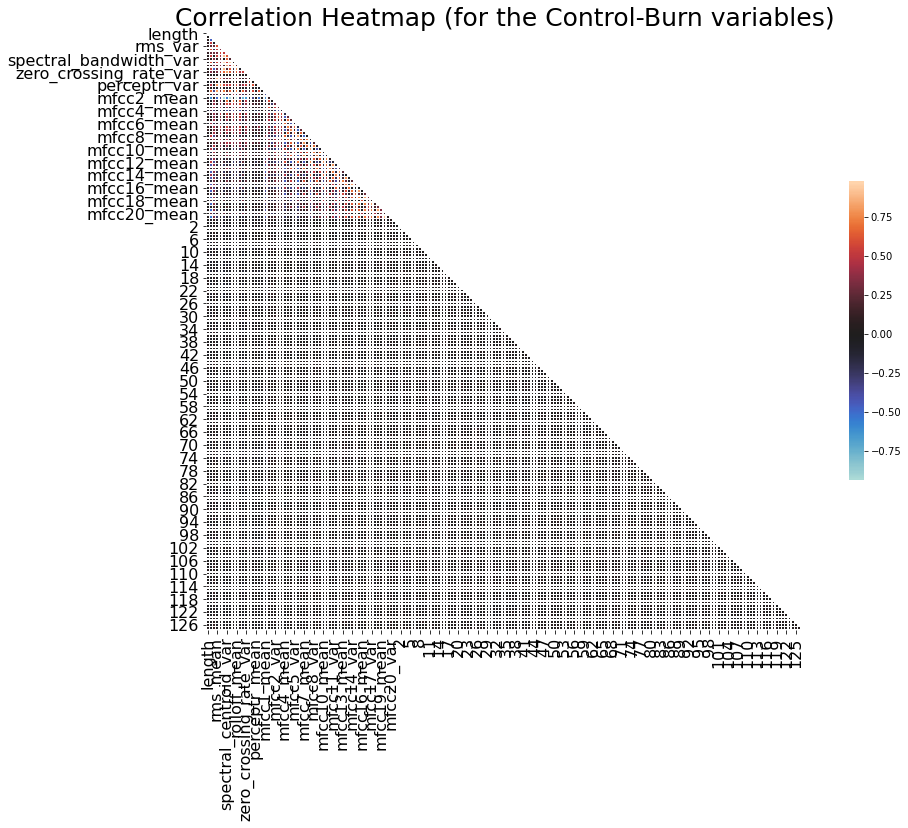

In [7]:
# Computing the Correlation Matrix
import seaborn as sns
data=df
spike_cols = [col for col in data.columns ]
corr = data[spike_cols].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(16, 11));

# Generate a custom diverging colormap
cmap = sns.diverging_palette(0, 25, as_cmap=True, s = 90, l = 45, n = 5)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask,  center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},)

plt.title('Correlation Heatmap (for the Control-Burn variables)', fontsize = 25)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16);
plt.savefig("Corr Heatmap.jpg")

# Project to 2D manifold

## PCA =2D

In [9]:
from sklearn.decomposition import KernelPCA
# transformer = KernelPCA(n_components=2, kernel='rbf')
transformer=PCA(n_components= 100)
kpca_mfccs_total = transformer.fit_transform(mfccs_total)
kpca_mfccs_total

NameError: name 'PCA' is not defined

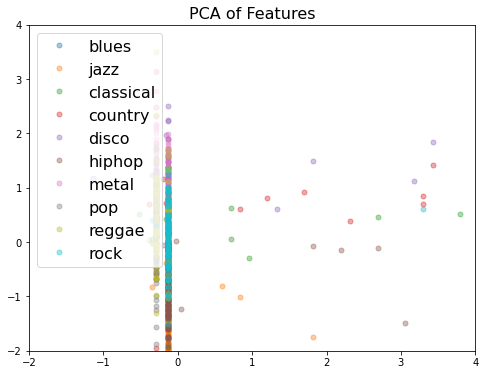

In [10]:
scaler = StandardScaler()
x_pca=scaler.fit_transform(kpca_mfccs_total)

labels=np.array(y)
df_pca=pd.DataFrame(x_pca)
df_pca['label']=labels
groups = df_pca.groupby('label')
fig, ax = plt.subplots(figsize=(8,6))
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

name_list=['blues','jazz','classical', 'country','disco','hiphop','metal','pop','reggae','rock']
for name, group in groups:
    ax.plot(group.iloc[:,0], group.iloc[:,1], marker='o', linestyle='', ms=5, alpha=0.4,label=name_list[name])
ax.legend(loc='upper left',fontsize=16)
ax.set_title('PCA of Features',fontsize=16)
ax.set_xlim([-2,4])
ax.set_ylim([-2,4])
plt.show()

## TSNE

In [1200]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=3, early_exaggeration=12, n_iter=1000, learning_rate=20,verbose=100, random_state=123)
tsne= tsne.fit_transform(X)
kpca_mfccs_total = tsne
kpca_mfccs_total

/Users/shuofeng/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.000s...
[t-SNE] Computed neighbors for 1000 samples in 0.036s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 3.446713
[t-SNE] Computed conditional probabilities in 0.026s
[t-SNE] Iteration 50: error = 65.0150223, gradient norm = 0.0000005 (50 iterations in 3.212s)
[t-SNE] Iteration 100: error = 65.0150223, gradient norm = 0.0000000 (50 iterations in 5.403s)
[t-SNE] Iteration 100: gradient norm 0.000000. Finished.
[t-SNE] KL divergence after 100 iterations with early exaggeration: 65.015022
[t-SNE] Iteration 150: error = 2.7473209, gradient norm = 0.0157245 (50 iterations in 9.357s)
[t-SNE] Iteration 200: error = 1.8215908, gradient norm = 0.0015247 (50 iterations in 6.846s)
[t-SNE] Iteration 250: error = 1.7779993, gradient norm = 0.0006366 (50 iterations in 5.114s)
[t-SNE] Iteration 300: error = 1.7633681, gradient norm = 0.0004617 (50 iterations in 5.247s)
[t-SNE] Ite

array([[ -1.0754386,  20.201387 ,   1.4752849],
       [  3.307493 ,   5.250192 ,  13.396981 ],
       [  5.564842 ,  -8.4086075,  21.152922 ],
       ...,
       [ -1.3831848,   2.8753426,  -2.5343606],
       [ -8.13024  ,  11.807359 , -10.457657 ],
       [ 12.503989 ,   9.999522 ,   9.075075 ]], dtype=float32)

## KNN

In [11]:
from sklearn.neighbors import NearestNeighbors
num_neigh = 120
neigh1 = NearestNeighbors(n_neighbors=num_neigh, radius=0.5, metric = 'jaccard')
neigh1.fit(kpca_mfccs_total)

NearestNeighbors(metric='jaccard', n_neighbors=120, radius=0.5)

In [14]:
adj_matrix_total = np.zeros((len(labels_total),len(labels_total)))

for i in tqdm(range(len(labels_total))):
    
    dist1, nbors1 =neigh1.kneighbors([kpca_mfccs_total[i,:]])
    #only keep train neighbor
    dist1 = dist1[nbors1<len(labels_train)]
    nbors1 = nbors1[nbors1<len(labels_train)]
    
    n_total = []
    n_total.append(nbors1)
    
    dist_total = []
    dist_total.append(dist1)
   
    neigh_total = np.array(n_total).squeeze().flatten()
    dist_total = np.array(dist_total).squeeze().flatten()
    
    neigh_total = np.unique(neigh_total)
    #dist_total = np.unique(dist_total)
    
    for j in range(len(neigh_total)):
        adj_matrix_total[i,neigh_total[j]] = dist_total[j]
        adj_matrix_total[neigh_total[j],i] = dist_total[j]
        



  0%|          | 0/1000 [00:00<?, ?it/s]/Users/shuofeng/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:1870: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/shuofeng/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:1870: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/shuofeng/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:1870: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/shuofeng/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:1870: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/shuofeng/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:1870: DataConversionWarning: Data was conv

 11%|█         | 110/1000 [00:00<00:00, 1098.11it/s]/Users/shuofeng/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:1870: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/shuofeng/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:1870: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/shuofeng/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:1870: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/shuofeng/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:1870: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/shuofeng/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:1870: DataConversionWarning: D

 22%|██▏       | 220/1000 [00:00<00:00, 1097.85it/s]/Users/shuofeng/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:1870: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/shuofeng/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:1870: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/shuofeng/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:1870: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/shuofeng/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:1870: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/shuofeng/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:1870: DataConversionWarning: D

 35%|███▌      | 350/1000 [00:00<00:00, 1150.09it/s]/Users/shuofeng/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:1870: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/shuofeng/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:1870: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/shuofeng/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:1870: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/shuofeng/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:1870: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/shuofeng/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:1870: DataConversionWarning: D

 48%|████▊     | 481/1000 [00:00<00:00, 1190.93it/s]/Users/shuofeng/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:1870: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/shuofeng/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:1870: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/shuofeng/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:1870: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/shuofeng/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:1870: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/shuofeng/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:1870: DataConversionWarning: D

 61%|██████    | 612/1000 [00:00<00:00, 1222.30it/s]/Users/shuofeng/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:1870: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/shuofeng/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:1870: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/shuofeng/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:1870: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/shuofeng/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:1870: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/shuofeng/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:1870: DataConversionWarning: D

 74%|███████▍  | 744/1000 [00:00<00:00, 1248.00it/s]/Users/shuofeng/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:1870: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/shuofeng/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:1870: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/shuofeng/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:1870: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/shuofeng/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:1870: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/shuofeng/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:1870: DataConversionWarning: D

 88%|████████▊ | 878/1000 [00:00<00:00, 1272.43it/s]/Users/shuofeng/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:1870: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/shuofeng/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:1870: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/shuofeng/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:1870: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/shuofeng/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:1870: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/shuofeng/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:1870: DataConversionWarning: D

100%|██████████| 1000/1000 [00:00<00:00, 1252.69it/s]


In [15]:
len(dist_total)

44

In [16]:
#train graph
nx_graph_train = nx.from_numpy_matrix(adj_matrix_total[0:len(labels_train),0:len(labels_train)])
g_dgl_euclid_train = dgl.from_networkx(nx_graph_train)
g_dgl_euclid_train

Graph(num_nodes=670, num_edges=0,
      ndata_schemes={}
      edata_schemes={})

In [17]:
#test graph
nx_graph_test = nx.from_numpy_matrix(adj_matrix_total[len(labels_train):,len(labels_train):])
g_dgl_euclid_test = dgl.from_networkx(nx_graph_test)
g_dgl_euclid_test

Graph(num_nodes=330, num_edges=0,
      ndata_schemes={}
      edata_schemes={})

In [18]:
#Total Graph
nx_graph_total= nx.from_numpy_matrix(adj_matrix_total)
g_dgl_euclid_total = dgl.from_networkx(nx_graph_total)
g_dgl_euclid_total

Graph(num_nodes=1000, num_edges=0,
      ndata_schemes={}
      edata_schemes={})

# Construct Graph Embedding Extractor

In [19]:
import dgl
import dgl.function as fn
import torch as th
import torch.nn as nn
import torch.nn.functional as F
from dgl import DGLGraph

gcn_msg = fn.copy_src(src='h', out='m')
gcn_reduce = fn.sum(msg='m', out='h')

gcn_reduce

In [20]:
def evaluate(model, g, features, labels, mask):
    model.eval()
    with th.no_grad():
        logits = model(g, features)
        logits = logits[mask]
        labels = labels[mask]
        _, indices = th.max(logits, dim=1)
        correct = th.sum(indices == labels)
        return correct.item() * 1.0 / len(labels)

In [21]:
def metrics_summary(val, pred):
    sens = recall_score(val, pred)
    spec = recall_score(1-val, 1-pred)
    prec = precision_score(val, pred)
    harmonic = 2*spec*sens/(sens+spec)

    print("prec: ", prec)
    print("sens: ", sens)
    print("spec: ", spec)
    print("harmonic: ", harmonic)


In [22]:
###create train and valid
train_len = len(labels_train)
train_mask_full = np.full(len(labels_total),True)
train_mask_full[train_len:]= False
valid_mask_full = ~train_mask_full
t_mask = th.BoolTensor(train_mask_full)
v_mask = th.BoolTensor(valid_mask_full)
inputs_g_total = torch.tensor(kpca_mfccs_total).float()
labels_graph = torch.tensor(labels_total).long()


In [23]:
###create train and valid

train_mask = np.full(len(labels_train),True)
t_mask2 = th.BoolTensor(train_mask)

test_mask = np.full(len(labels_test),True)
t_mask_test = th.BoolTensor(test_mask)


inputs_g_train = torch.tensor(kpca_mfccs_total[:len(labels_train)]).float()
labels_graph_train = torch.tensor(labels_train).long()

inputs_g_test = torch.tensor(kpca_mfccs_total[len(labels_train):]).float()
labels_graph_test = torch.tensor(labels_test).long()



In [24]:
train_mask_total = np.full(len(labels_total),True)
t_mask_total = th.BoolTensor(train_mask_total)

In [25]:
# Contruct a two-layer GNN model
import dgl.nn as dglnn
import torch.nn as nn
import torch.nn.functional as F
class SAGE(nn.Module):
    def __init__(self, in_feats, hid_feats, out_feats):
        super().__init__()
        self.conv1 = dglnn.SAGEConv(
            in_feats=in_feats, out_feats=hid_feats, aggregator_type='mean',feat_drop=0.01)
        self.conv2 = dglnn.SAGEConv(
            in_feats=hid_feats, out_feats=hid_feats, aggregator_type='mean',feat_drop=0.01)
        self.conv3 = dglnn.SAGEConv(
            in_feats=hid_feats, out_feats=out_feats, aggregator_type='mean')

    def forward(self, graph, inputs):
        # inputs are features of nodes
        h = self.conv1(graph, inputs)
        h = F.relu(h)
        h = self.conv2(graph, h)
        h = F.relu(h)
        h = self.conv2(graph, h)
        h = F.relu(h)
        h = self.conv2(graph, h)
        h = F.relu(h)
        h = self.conv2(graph, h)
        h = F.relu(h)
        h = self.conv2(graph, h)
        h = F.relu(h)
        h = self.conv3(graph, h)
        
        return h


In [26]:
labels_graph_train.shape

torch.Size([670])

In [29]:
model_gsage = SAGE(in_feats= 186, hid_feats=150, out_feats=10)
opt = th.optim.Adam(model_gsage.parameters(),lr=1e-3)
model_gsage.train()
loss_list=[]
acc_list=[]
acc_test_list=[]
for epoch in range(800):
    out = model_gsage(g_dgl_euclid_train, inputs_g_train)
    # compute loss
    loss = F.cross_entropy(out, labels_graph_train)
    # compute validation accuracy
    acc = evaluate(model_gsage, g_dgl_euclid_train, inputs_g_train, labels_graph_train, t_mask2)
    acc_test=evaluate(model_gsage, g_dgl_euclid_test, inputs_g_test, labels_graph_test, t_mask_test)
    loss_list.append(loss.detach().numpy())
    acc_list.append(acc)
    acc_test_list.append(acc_test)
    opt.zero_grad()
    loss.backward()
    opt.step()
    print("Epoch {:05d} | Loss {:.4f} | Train Acc {:.4f}| Test Acc {:.4f}".format(
            epoch, loss.item(), acc,acc_test))

Epoch 00000 | Loss 6.1527 | Train Acc 0.0985| Test Acc 0.1000
Epoch 00001 | Loss 3.9003 | Train Acc 0.1000| Test Acc 0.1212
Epoch 00002 | Loss 3.0080 | Train Acc 0.1149| Test Acc 0.1182
Epoch 00003 | Loss 2.6027 | Train Acc 0.1328| Test Acc 0.1303
Epoch 00004 | Loss 2.4006 | Train Acc 0.1478| Test Acc 0.1242
Epoch 00005 | Loss 2.2912 | Train Acc 0.1597| Test Acc 0.1303
Epoch 00006 | Loss 2.2117 | Train Acc 0.1970| Test Acc 0.1242
Epoch 00007 | Loss 2.1479 | Train Acc 0.2090| Test Acc 0.1364
Epoch 00008 | Loss 2.0990 | Train Acc 0.2224| Test Acc 0.1212
Epoch 00009 | Loss 2.0617 | Train Acc 0.2672| Test Acc 0.1455
Epoch 00010 | Loss 2.0318 | Train Acc 0.2806| Test Acc 0.1424
Epoch 00011 | Loss 2.0028 | Train Acc 0.3239| Test Acc 0.1455
Epoch 00012 | Loss 1.9730 | Train Acc 0.3567| Test Acc 0.1485
Epoch 00013 | Loss 1.9417 | Train Acc 0.3821| Test Acc 0.1636
Epoch 00014 | Loss 1.9085 | Train Acc 0.4075| Test Acc 0.1788
Epoch 00015 | Loss 1.8724 | Train Acc 0.4388| Test Acc 0.2030
Epoch 00

Epoch 00134 | Loss 0.0023 | Train Acc 1.0000| Test Acc 0.4212
Epoch 00135 | Loss 0.0023 | Train Acc 1.0000| Test Acc 0.4212
Epoch 00136 | Loss 0.0023 | Train Acc 1.0000| Test Acc 0.4212
Epoch 00137 | Loss 0.0022 | Train Acc 1.0000| Test Acc 0.4212
Epoch 00138 | Loss 0.0022 | Train Acc 1.0000| Test Acc 0.4212
Epoch 00139 | Loss 0.0022 | Train Acc 1.0000| Test Acc 0.4212
Epoch 00140 | Loss 0.0021 | Train Acc 1.0000| Test Acc 0.4212
Epoch 00141 | Loss 0.0021 | Train Acc 1.0000| Test Acc 0.4212
Epoch 00142 | Loss 0.0021 | Train Acc 1.0000| Test Acc 0.4182
Epoch 00143 | Loss 0.0020 | Train Acc 1.0000| Test Acc 0.4182
Epoch 00144 | Loss 0.0020 | Train Acc 1.0000| Test Acc 0.4182
Epoch 00145 | Loss 0.0020 | Train Acc 1.0000| Test Acc 0.4182
Epoch 00146 | Loss 0.0020 | Train Acc 1.0000| Test Acc 0.4182
Epoch 00147 | Loss 0.0019 | Train Acc 1.0000| Test Acc 0.4182
Epoch 00148 | Loss 0.0019 | Train Acc 1.0000| Test Acc 0.4182
Epoch 00149 | Loss 0.0019 | Train Acc 1.0000| Test Acc 0.4182
Epoch 00

Epoch 00269 | Loss 0.0006 | Train Acc 1.0000| Test Acc 0.4242
Epoch 00270 | Loss 0.0006 | Train Acc 1.0000| Test Acc 0.4242
Epoch 00271 | Loss 0.0006 | Train Acc 1.0000| Test Acc 0.4242
Epoch 00272 | Loss 0.0006 | Train Acc 1.0000| Test Acc 0.4242
Epoch 00273 | Loss 0.0006 | Train Acc 1.0000| Test Acc 0.4242
Epoch 00274 | Loss 0.0006 | Train Acc 1.0000| Test Acc 0.4242
Epoch 00275 | Loss 0.0006 | Train Acc 1.0000| Test Acc 0.4242
Epoch 00276 | Loss 0.0006 | Train Acc 1.0000| Test Acc 0.4242
Epoch 00277 | Loss 0.0006 | Train Acc 1.0000| Test Acc 0.4242
Epoch 00278 | Loss 0.0006 | Train Acc 1.0000| Test Acc 0.4242
Epoch 00279 | Loss 0.0006 | Train Acc 1.0000| Test Acc 0.4242
Epoch 00280 | Loss 0.0006 | Train Acc 1.0000| Test Acc 0.4242
Epoch 00281 | Loss 0.0006 | Train Acc 1.0000| Test Acc 0.4242
Epoch 00282 | Loss 0.0006 | Train Acc 1.0000| Test Acc 0.4242
Epoch 00283 | Loss 0.0005 | Train Acc 1.0000| Test Acc 0.4242
Epoch 00284 | Loss 0.0005 | Train Acc 1.0000| Test Acc 0.4242
Epoch 00

Epoch 00404 | Loss 0.0003 | Train Acc 1.0000| Test Acc 0.4273
Epoch 00405 | Loss 0.0003 | Train Acc 1.0000| Test Acc 0.4273
Epoch 00406 | Loss 0.0003 | Train Acc 1.0000| Test Acc 0.4273
Epoch 00407 | Loss 0.0003 | Train Acc 1.0000| Test Acc 0.4273
Epoch 00408 | Loss 0.0003 | Train Acc 1.0000| Test Acc 0.4303
Epoch 00409 | Loss 0.0003 | Train Acc 1.0000| Test Acc 0.4303
Epoch 00410 | Loss 0.0003 | Train Acc 1.0000| Test Acc 0.4303
Epoch 00411 | Loss 0.0003 | Train Acc 1.0000| Test Acc 0.4303
Epoch 00412 | Loss 0.0003 | Train Acc 1.0000| Test Acc 0.4303
Epoch 00413 | Loss 0.0003 | Train Acc 1.0000| Test Acc 0.4303
Epoch 00414 | Loss 0.0003 | Train Acc 1.0000| Test Acc 0.4303
Epoch 00415 | Loss 0.0003 | Train Acc 1.0000| Test Acc 0.4303
Epoch 00416 | Loss 0.0003 | Train Acc 1.0000| Test Acc 0.4303
Epoch 00417 | Loss 0.0003 | Train Acc 1.0000| Test Acc 0.4303
Epoch 00418 | Loss 0.0003 | Train Acc 1.0000| Test Acc 0.4303
Epoch 00419 | Loss 0.0003 | Train Acc 1.0000| Test Acc 0.4303
Epoch 00

Epoch 00540 | Loss 0.0002 | Train Acc 1.0000| Test Acc 0.4303
Epoch 00541 | Loss 0.0002 | Train Acc 1.0000| Test Acc 0.4303
Epoch 00542 | Loss 0.0002 | Train Acc 1.0000| Test Acc 0.4303
Epoch 00543 | Loss 0.0002 | Train Acc 1.0000| Test Acc 0.4303
Epoch 00544 | Loss 0.0002 | Train Acc 1.0000| Test Acc 0.4303
Epoch 00545 | Loss 0.0002 | Train Acc 1.0000| Test Acc 0.4303
Epoch 00546 | Loss 0.0002 | Train Acc 1.0000| Test Acc 0.4303
Epoch 00547 | Loss 0.0002 | Train Acc 1.0000| Test Acc 0.4303
Epoch 00548 | Loss 0.0002 | Train Acc 1.0000| Test Acc 0.4303
Epoch 00549 | Loss 0.0002 | Train Acc 1.0000| Test Acc 0.4303
Epoch 00550 | Loss 0.0002 | Train Acc 1.0000| Test Acc 0.4303
Epoch 00551 | Loss 0.0002 | Train Acc 1.0000| Test Acc 0.4303
Epoch 00552 | Loss 0.0002 | Train Acc 1.0000| Test Acc 0.4303
Epoch 00553 | Loss 0.0002 | Train Acc 1.0000| Test Acc 0.4303
Epoch 00554 | Loss 0.0002 | Train Acc 1.0000| Test Acc 0.4303
Epoch 00555 | Loss 0.0002 | Train Acc 1.0000| Test Acc 0.4303
Epoch 00

Epoch 00677 | Loss 0.0001 | Train Acc 1.0000| Test Acc 0.4333
Epoch 00678 | Loss 0.0001 | Train Acc 1.0000| Test Acc 0.4333
Epoch 00679 | Loss 0.0001 | Train Acc 1.0000| Test Acc 0.4333
Epoch 00680 | Loss 0.0001 | Train Acc 1.0000| Test Acc 0.4333
Epoch 00681 | Loss 0.0001 | Train Acc 1.0000| Test Acc 0.4333
Epoch 00682 | Loss 0.0001 | Train Acc 1.0000| Test Acc 0.4333
Epoch 00683 | Loss 0.0001 | Train Acc 1.0000| Test Acc 0.4333
Epoch 00684 | Loss 0.0001 | Train Acc 1.0000| Test Acc 0.4333
Epoch 00685 | Loss 0.0001 | Train Acc 1.0000| Test Acc 0.4333
Epoch 00686 | Loss 0.0001 | Train Acc 1.0000| Test Acc 0.4333
Epoch 00687 | Loss 0.0001 | Train Acc 1.0000| Test Acc 0.4333
Epoch 00688 | Loss 0.0001 | Train Acc 1.0000| Test Acc 0.4333
Epoch 00689 | Loss 0.0001 | Train Acc 1.0000| Test Acc 0.4333
Epoch 00690 | Loss 0.0001 | Train Acc 1.0000| Test Acc 0.4333
Epoch 00691 | Loss 0.0001 | Train Acc 1.0000| Test Acc 0.4333
Epoch 00692 | Loss 0.0001 | Train Acc 1.0000| Test Acc 0.4333
Epoch 00

In [30]:
# torch.save(model_gsage.state_dict(),'model_weights.pt')

In [31]:
out = model_gsage(g_dgl_euclid_total, inputs_g_total)
tot_embed = out.cpu().detach().numpy()

In [32]:
acc = evaluate(model_gsage, g_dgl_euclid_train, inputs_g_train, labels_graph_train, t_mask2)
acc

1.0

In [33]:
acc = evaluate(model_gsage, g_dgl_euclid_test, inputs_g_test, labels_graph_test, t_mask_test)
acc

0.43333333333333335

In [34]:
loss_list

[array(6.152737, dtype=float32),
 array(3.9003253, dtype=float32),
 array(3.0080032, dtype=float32),
 array(2.602736, dtype=float32),
 array(2.4005737, dtype=float32),
 array(2.2911828, dtype=float32),
 array(2.2116683, dtype=float32),
 array(2.1478615, dtype=float32),
 array(2.0990286, dtype=float32),
 array(2.0616546, dtype=float32),
 array(2.0317812, dtype=float32),
 array(2.0028281, dtype=float32),
 array(1.9729635, dtype=float32),
 array(1.9417342, dtype=float32),
 array(1.9085472, dtype=float32),
 array(1.8724465, dtype=float32),
 array(1.8333569, dtype=float32),
 array(1.7913399, dtype=float32),
 array(1.7466044, dtype=float32),
 array(1.6986767, dtype=float32),
 array(1.6476575, dtype=float32),
 array(1.5951806, dtype=float32),
 array(1.5424671, dtype=float32),
 array(1.4891255, dtype=float32),
 array(1.435221, dtype=float32),
 array(1.3799802, dtype=float32),
 array(1.3237078, dtype=float32),
 array(1.2660257, dtype=float32),
 array(1.2077761, dtype=float32),
 array(1.1496665,

Text(0.5, 1.0, 'Learning Curve')

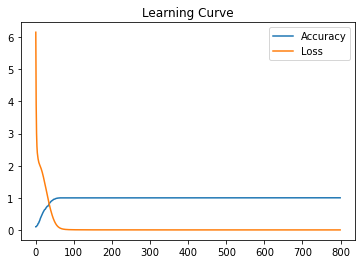

In [35]:
plt.plot(acc_list,label='Accuracy')
plt.plot(loss_list,label='Loss')
plt.legend()
plt.title('Learning Curve')

# Corss - Validation

In [36]:
prob=torch.softmax(out[t_mask],1).cpu().detach().numpy()

In [38]:
prob=pd.DataFrame(prob)
prob

,0,1,2,3,4,5,6,7,8,9
0,3.886042e-23,1.840703e-26,7.774239e-15,1.393066e-18,1.252771e-14,2.184318e-11,1.083261e-29,1.000000e+00,9.364144e-17,2.195949e-28
1,9.999356e-01,2.264484e-08,2.398994e-05,5.153640e-13,6.528487e-08,2.164438e-10,1.073992e-13,4.062184e-11,4.634669e-10,4.024300e-05
2,3.411159e-08,2.972222e-07,6.101832e-05,4.703016e-08,8.501780e-08,9.999158e-01,7.211551e-09,2.109428e-09,2.209771e-05,6.314941e-07
3,1.589878e-08,2.467985e-12,3.400263e-10,7.788675e-07,4.287411e-07,4.020206e-14,9.999981e-01,1.056659e-12,1.460071e-15,7.402699e-07
4,5.210910e-08,5.397711e-13,6.041669e-09,5.271404e-10,5.587159e-10,3.062291e-15,7.902147e-06,3.091128e-15,1.369578e-14,9.999921e-01
...,...,...,...,...,...,...,...,...,...,...
665,5.797393e-06,1.579951e-04,4.744970e-08,6.513038e-08,6.727924e-09,9.998305e-01,4.139193e-06,3.870488e-07,2.799955e-09,1.026608e-06
666,2.339453e-16,5.196426e-16,3.659643e-09,9.806606e-14,9.999689e-01,2.257040e-14,2.253182e-14,7.002112e-08,3.100209e-05,2.789488e-10
667,1.798633e-12,2.106851e-14,9.999815e-01,2.828924e-08,7.293052e-07,1.048128e-07,1.721774e-10,1.768798e-05,7.243871e-09,3.787445e-09
668,2.703998e-05,5.944802e-08,9.997302e-01,4.301147e-07,1.399546e-04,8.471277e-08,4.347511e-06,4.037274e-08,3.477371e-06,9.440508e-05


# Extract Positive and Negative Edges

In [22]:
num_neigh = 15
neigh_graph = NearestNeighbors(n_neighbors=num_neigh, radius=0.5)
neigh_graph.fit(tot_embed)

NearestNeighbors(n_neighbors=15, radius=0.5)

In [23]:
adj_matrix_total_neg = np.zeros((len(tot_embed),len(tot_embed)))
adj_matrix_total_pos = np.zeros((len(tot_embed),len(tot_embed)))
adj_matrix_total_pos[:len(labels_train),:len(labels_train)] =  adj_matrix_total[:len(labels_train),:len(labels_train)]

for i in tqdm(range(len(labels_train))):
    n_total = []
    n_total2 = []
    label = labels_train[i]
    dist, nbors =neigh_graph.kneighbors([tot_embed[i,:]])
    nbors = nbors[nbors<len(labels_train)]
    n_total.append(nbors[labels_train[nbors]!=label])
    n_total2.append(nbors[labels_train[nbors]==label])

    neigh_total = np.array(n_total).squeeze().flatten()
    neigh_total = np.unique(neigh_total)
    adj_matrix_total_neg[i,neigh_total] = 1
    adj_matrix_total_neg[neigh_total,i] = 1
    
    neigh_total2 = np.array(n_total2).squeeze().flatten()
    neigh_total2 = np.unique(neigh_total2)
    adj_matrix_total_pos[i,neigh_total2] = 1
    adj_matrix_total_pos[neigh_total2,i] = 1
    
    

100%|██████████| 1340/1340 [00:00<00:00, 2741.36it/s]


In [24]:
pos1,pos2 =np.where((adj_matrix_total_pos-np.eye(len(tot_embed)))==1)
neg1,neg2 =np.where(adj_matrix_total_neg==1)
train_neg_g_syn = dgl.graph((neg1, neg2), num_nodes=len(adj_matrix_total_neg))
train_pos_g_syn = dgl.graph((pos1, pos2), num_nodes=len(adj_matrix_total_pos))

# Construct the Edge Model

In [25]:
class DotPredictor(nn.Module):
    def forward(self, g, h):
        with g.local_scope():
            g.ndata['h'] = h
            g.apply_edges(fn.u_dot_v('h', 'h', 'score'))
            return g.edata['score'][:, 0]

In [26]:
pred = DotPredictor()

def compute_loss(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score])
    labels = torch.cat([torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])])
    return F.binary_cross_entropy_with_logits(scores, labels)



# Create the adjacency matrix for train+val

In [27]:
adj_matrix_train_val = np.zeros((len(tot_embed),len(tot_embed)))
adj_matrix_train_val[:len(labels_train),:len(labels_train)] =  adj_matrix_total[:len(labels_train),:len(labels_train)]
for i in tqdm(range(len(tot_embed))):
    n_total = []
    dist, nbors =neigh_graph.kneighbors([tot_embed[i,:]])
    nbors = nbors[nbors<len(labels_train)]
    n_total.append(nbors)

    neigh_total = np.array(n_total).squeeze().flatten()
    neigh_total = np.unique(neigh_total)
    adj_matrix_train_val[i,neigh_total] = 1
    adj_matrix_train_val[neigh_total,i] = 1
    
   
    

100%|██████████| 2000/2000 [00:00<00:00, 2962.58it/s]


In [28]:
pos1_val,pos2_val =np.where((adj_matrix_train_val-np.eye(len(tot_embed)))==1)
pos1_val,pos2_val = pos1_val[pos1_val>=len(labels_train)], pos2_val[pos1_val>=len(labels_train)]
pos_g_val = dgl.graph((pos1_val, pos2_val), num_nodes=len(tot_embed))

In [46]:
nx_graph_train_val = nx.from_numpy_matrix(adj_matrix_train_val)
##training on the positive edge graph, where edges for val nodes are removed
nx_g_edge =  nx.from_numpy_matrix(adj_matrix_total_pos)
g_dgl_euclid_edge = dgl.from_networkx(nx_g_edge)

In [53]:
class GraphSAGE_edge(nn.Module):
    def __init__(self, in_feats, h_feats):
        super(GraphSAGE_edge, self).__init__()
        self.conv1 = dglnn.SAGEConv(in_feats, h_feats, 'mean')
        self.conv2 = dglnn.SAGEConv(h_feats, h_feats, 'mean')
    
    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        h = F.relu(h)
        h = self.conv2(g, h)
        h = F.relu(h)
        h = self.conv2(g, h)
        return h

In [54]:
g_dgl_euclid_edge.ndata['feat'] =  torch.tensor(tot_embed).float()
model_edge = GraphSAGE_edge(g_dgl_euclid_edge.ndata['feat'].shape[1], 50)


In [56]:
import itertools

optimizer = torch.optim.Adam(itertools.chain(model_edge.parameters(), pred.parameters()), lr=1e-4)
for i in range(400):
    h = model_edge(g_dgl_euclid_edge, g_dgl_euclid_edge.ndata['feat'])
    pos_score = pred(train_pos_g_syn, h)
    neg_score = pred(train_neg_g_syn, h)
    loss = compute_loss(pos_score, neg_score)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print('Epoch {}, loss: {}'.format(i, loss))


Epoch 0, loss: 0.19690021872520447
Epoch 1, loss: 0.19680526852607727
Epoch 2, loss: 0.19673363864421844
Epoch 3, loss: 0.19665920734405518
Epoch 4, loss: 0.19658762216567993
Epoch 5, loss: 0.19652009010314941
Epoch 6, loss: 0.19646096229553223
Epoch 7, loss: 0.19639137387275696
Epoch 8, loss: 0.19633501768112183
Epoch 9, loss: 0.1962728053331375
Epoch 10, loss: 0.1962108612060547
Epoch 11, loss: 0.19615595042705536
Epoch 12, loss: 0.19609498977661133
Epoch 13, loss: 0.19603712856769562
Epoch 14, loss: 0.19598248600959778
Epoch 15, loss: 0.19592395424842834
Epoch 16, loss: 0.1958690583705902
Epoch 17, loss: 0.19581468403339386
Epoch 18, loss: 0.19575782120227814
Epoch 19, loss: 0.19570420682430267
Epoch 20, loss: 0.19565021991729736
Epoch 21, loss: 0.19559556245803833
Epoch 22, loss: 0.19554352760314941
Epoch 23, loss: 0.19549046456813812
Epoch 24, loss: 0.19543810188770294
Epoch 25, loss: 0.19538752734661102
Epoch 26, loss: 0.1953359991312027
Epoch 27, loss: 0.1952858865261078
Epoch 2

Epoch 232, loss: 0.18458907306194305
Epoch 233, loss: 0.18453074991703033
Epoch 234, loss: 0.18447256088256836
Epoch 235, loss: 0.1844143271446228
Epoch 236, loss: 0.18435612320899963
Epoch 237, loss: 0.18429775536060333
Epoch 238, loss: 0.18423932790756226
Epoch 239, loss: 0.1841810643672943
Epoch 240, loss: 0.18412290513515472
Epoch 241, loss: 0.18406476080417633
Epoch 242, loss: 0.1840064972639084
Epoch 243, loss: 0.18394839763641357
Epoch 244, loss: 0.18389056622982025
Epoch 245, loss: 0.18383310735225677
Epoch 246, loss: 0.18377572298049927
Epoch 247, loss: 0.18371833860874176
Epoch 248, loss: 0.1836608350276947
Epoch 249, loss: 0.18360310792922974
Epoch 250, loss: 0.18354541063308716
Epoch 251, loss: 0.18348778784275055
Epoch 252, loss: 0.1834300458431244
Epoch 253, loss: 0.18337242305278778
Epoch 254, loss: 0.18331454694271088
Epoch 255, loss: 0.18325668573379517
Epoch 256, loss: 0.18319886922836304
Epoch 257, loss: 0.18314112722873688
Epoch 258, loss: 0.183083638548851
Epoch 25

In [59]:
len(pos_score_val)

5477

# Filter the val edges out 

In [60]:
pos_score_val = pred(pos_g_val, h).detach().numpy()
threshold = np.percentile(pos_score_val, 20)

adj_matrix_total_new2 = np.zeros((len(tot_embed),len(tot_embed)))
adj_matrix_total_new2[:len(labels_train),:len(labels_train)] = adj_matrix_train_val[:len(labels_train),:len(labels_train)]
idx1,idx2 = pos1_val[pos_score_val>threshold],pos2_val[pos_score_val>threshold]
adj_matrix_total_new2[idx1,idx2] = 1
adj_matrix_total_new2[idx2,idx1] = 1
    

In [61]:
nx_graph_new2 = nx.from_numpy_matrix(adj_matrix_total_new2)
g_dgl_euclid_new2 = dgl.from_networkx(nx_graph_new2)


In [62]:
nx_graph_train2 = nx.from_numpy_matrix(adj_matrix_total_new2[:len(labels_train),:len(labels_train)])
g_dgl_euclid_train2 = dgl.from_networkx(nx_graph_train2)


# Train New Model 

In [191]:
###create train and valid

inputs_g_total = torch.tensor(tot_embed).float()
inputs_g_train = torch.tensor(tot_embed[:len(labels_train)]).float()
inputs_g_test = torch.tensor(tot_embed[len(labels_train):]).float()


torch.Size([660, 2])

In [65]:
model_gsage_final = SAGE(in_feats=2, hid_feats=100, out_feats=2)
opt = th.optim.Adam(model_gsage_final.parameters(),lr=1e-3)

for epoch in range(250):
    model_gsage_final.train()
    out = model_gsage_final(g_dgl_euclid_train2, inputs_g_train)
    loss = F.cross_entropy(out, labels_graph_train)
    acc = evaluate(model_gsage_final, g_dgl_euclid_train2, inputs_g_train, labels_graph_train, t_mask2)
    opt.zero_grad()
    loss.backward()
    opt.step()
    print("Epoch {:05d} | Loss {:.4f} | Test Acc {:.4f} |".format(
            epoch, loss.item(), acc))



Epoch 00000 | Loss 0.8865 | Test Acc 0.5097 |
Epoch 00001 | Loss 0.9620 | Test Acc 0.5381 |
Epoch 00002 | Loss 0.8130 | Test Acc 0.5418 |
Epoch 00003 | Loss 0.6890 | Test Acc 0.5463 |
Epoch 00004 | Loss 0.7868 | Test Acc 0.5097 |
Epoch 00005 | Loss 0.7532 | Test Acc 0.5097 |
Epoch 00006 | Loss 0.6841 | Test Acc 0.5612 |
Epoch 00007 | Loss 0.7180 | Test Acc 0.5366 |
Epoch 00008 | Loss 0.7203 | Test Acc 0.5425 |
Epoch 00009 | Loss 0.6943 | Test Acc 0.5642 |
Epoch 00010 | Loss 0.6838 | Test Acc 0.5433 |
Epoch 00011 | Loss 0.6988 | Test Acc 0.5149 |
Epoch 00012 | Loss 0.6966 | Test Acc 0.5216 |
Epoch 00013 | Loss 0.6858 | Test Acc 0.5552 |
Epoch 00014 | Loss 0.6779 | Test Acc 0.5746 |
Epoch 00015 | Loss 0.6867 | Test Acc 0.5769 |
Epoch 00016 | Loss 0.6828 | Test Acc 0.5784 |
Epoch 00017 | Loss 0.6774 | Test Acc 0.5821 |
Epoch 00018 | Loss 0.6762 | Test Acc 0.5784 |
Epoch 00019 | Loss 0.6696 | Test Acc 0.5754 |
Epoch 00020 | Loss 0.6765 | Test Acc 0.5724 |
Epoch 00021 | Loss 0.6751 | Test A

Epoch 00181 | Loss 0.6331 | Test Acc 0.6321 |
Epoch 00182 | Loss 0.6329 | Test Acc 0.6276 |
Epoch 00183 | Loss 0.6357 | Test Acc 0.6299 |
Epoch 00184 | Loss 0.6366 | Test Acc 0.6313 |
Epoch 00185 | Loss 0.6352 | Test Acc 0.6328 |
Epoch 00186 | Loss 0.6288 | Test Acc 0.6313 |
Epoch 00187 | Loss 0.6312 | Test Acc 0.6321 |
Epoch 00188 | Loss 0.6372 | Test Acc 0.6321 |
Epoch 00189 | Loss 0.6344 | Test Acc 0.6313 |
Epoch 00190 | Loss 0.6300 | Test Acc 0.6299 |
Epoch 00191 | Loss 0.6282 | Test Acc 0.6276 |
Epoch 00192 | Loss 0.6348 | Test Acc 0.6313 |
Epoch 00193 | Loss 0.6306 | Test Acc 0.6299 |
Epoch 00194 | Loss 0.6302 | Test Acc 0.6306 |
Epoch 00195 | Loss 0.6369 | Test Acc 0.6373 |
Epoch 00196 | Loss 0.6344 | Test Acc 0.6366 |
Epoch 00197 | Loss 0.6316 | Test Acc 0.6373 |
Epoch 00198 | Loss 0.6347 | Test Acc 0.6373 |
Epoch 00199 | Loss 0.6334 | Test Acc 0.6381 |
Epoch 00200 | Loss 0.6320 | Test Acc 0.6358 |
Epoch 00201 | Loss 0.6348 | Test Acc 0.6328 |
Epoch 00202 | Loss 0.6342 | Test A

# Apply SVM

In [70]:
out = model_gsage_final(g_dgl_euclid_new2, inputs_g_total)
x = out.detach().cpu().numpy()

tensor([[ 0.1691,  0.7955],
        [ 0.6252,  0.4386],
        [ 0.1905,  0.6531],
        ...,
        [ 0.3359,  0.4606],
        [ 0.1823,  0.2498],
        [-0.1014,  0.9239]], grad_fn=<AddBackward0>)

In [69]:
clf = svm.SVC(kernel='rbf',C=1.0,probability=True)
clf.fit(x[train_mask_full], labels_total[train_mask_full])
y_pred = clf.predict(x[valid_mask_full])
metrics_summary(labels_total[valid_mask_full],y_pred)

prec:  0.0
sens:  0.0
spec:  0.0
harmonic:  nan


/home/yazmine/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/yazmine/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-15-612d5ddbff83>:5: RuntimeWarning: invalid value encountered in double_scalars
  harmonic = 2*spec*sens/(sens+spec)
